In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models, layers
content_layers = ['block5_conv1']
style_layers = ['block1_conv1', 'block2_conv1', 
               'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content = len(content_layers)
num_style = len(style_layers)

style_path = '/content/drive/My Drive/waves.jpg'
content_path = '/content/drive/My Drive/TajMahal.jpg'

In [5]:
def show_imgs(imgs, titles):
    for i in range(len(imgs)):
        cv2.imshow(titles[i], imgs[i])
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [6]:
def load_image(path):
    img = cv2.imread(path)
    img = img.astype(np.float32)/255.
    img = cv2.resize(img, (300, 300))
    img = img[np.newaxis, :]
    return img

content = load_image(content_path)
style = load_image(style_path)

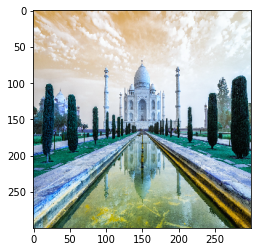

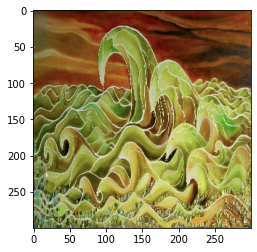

In [7]:
plt.imshow(content[0])
plt.show()
plt.imshow(style[0])
plt.show()

In [8]:
def get_model(content_layers = content_layers, style_layers = style_layers):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = style_outputs + content_outputs
    
    return models.Model(vgg.input, model_outputs)

In [9]:
class Style_Model(tf.keras.models.Model):
    def __init__(self, style_layers = style_layers, content_layers = content_layers):
        super(Style_Model, self).__init__()
        self.model = get_model(content_layers, style_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.model.trainable = False
        self.num_style = len(self.style_layers)
        
    def call(self, inputs):
    
        inputs = inputs * 255.
        preproc = preprocess_input(inputs)
        outputs = self.model(preproc)

        style_outputs = [gram_matrix(i) for i in outputs[:self.num_style]]
        content_outputs = outputs[self.num_style:]

        content_dict = {name : value 
                        for name, value in zip(self.content_layers, content_outputs)}
        style_dict = {name : value 
                      for name, value in zip(self.style_layers, style_outputs)}

        return {'Content':content_dict, 'Style':style_dict}

In [10]:
def content_loss(base, target):
    return tf.reduce_mean(tf.square(base - target))

In [11]:
def gram_matrix(input):
    result = tf.linalg.einsum('bijc, bijd->bcd', input, input)
    shape = tf.shape(input)
    num_locs = tf.cast(shape[1]*shape[2], tf.float32)
    return result/num_locs
    # temp = tf.squeeze(tensor)
    # res = tf.matmul(temp, temp, transpose_b = True)
    # gram = tf.expand_dims(res, axis = 0)
    # return gram

In [12]:
def style_loss(base, target):
#     h, w, ch = list(base.shape())
    g_style = gram_matrix(base)
    return tf.reduce_mean(tf.square(g_style - target))

In [13]:
neural_model = Style_Model(style_layers, content_layers)
style_targets = neural_model(style)['Style']
content_targets = neural_model(content)['Content']

80142336/80134624 [==============================] - 2s 0us/step


In [14]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

In [15]:
# Custom weights for style and content updates
style_weight=100
content_weight=100

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.0,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

total_var_weight = 1e8

In [16]:
def total_loss(output):
  s_out = output['Style']
  c_out = output['Content']
  s_loss = tf.add_n([style_weights[name]*
                     tf.reduce_mean((s_out[name] - style_targets[name])**2) 
                     for name in s_out.keys()])
  s_loss *= style_weight/num_style

  c_loss = tf.add_n(
      [content_loss(c_out[name], content_targets[name])**2]
      for name in c_out.keys())
  c_loss *= content_weight/num_content

  return s_loss + c_loss


In [17]:
def high_pass(img):
  x_var = img[:,:,1:,:] - img[:,:,:-1,:]
  y_var = img[:,1:,:,:] - img[:,:-1,:,:]
  return x_var, y_var

In [18]:
def total_var_loss(img):
  x_del, y_del = high_pass(img)
  return tf.reduce_mean(x_del**2) + tf.reduce_mean(y_del**2)

In [19]:
def train_step(img):
  with tf.GradientTape() as tape:
    outputs = neural_model(img)
    loss = total_loss(outputs)
    loss += total_var_weight*total_var_loss(img)
  
  gradient = tape.gradient(loss, img)
  optimizer.apply_gradients([(gradient, img)])
  img.assign(tf.clip_by_value(img, clip_value_min = 0.0, clip_value_max = 1.0))


In [20]:
target_img = tf.Variable(content)

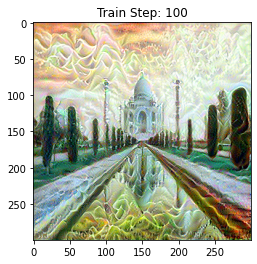

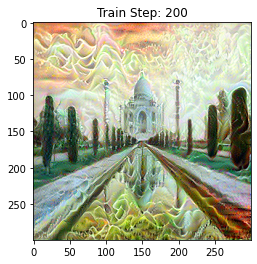

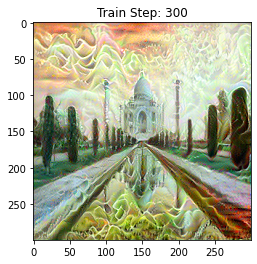

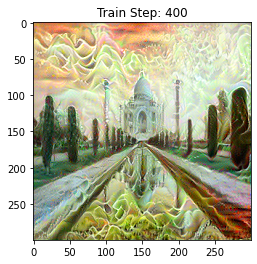

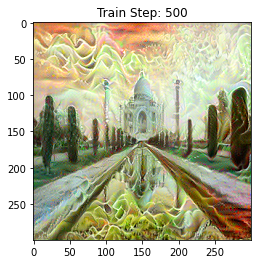

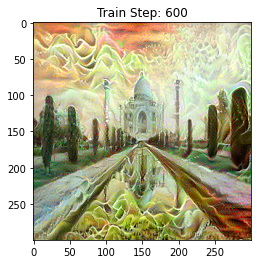

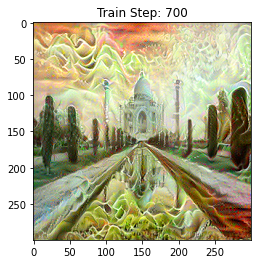

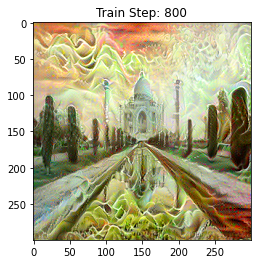

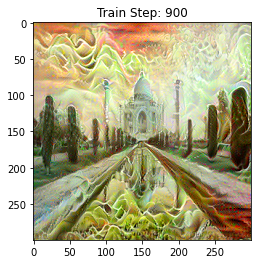

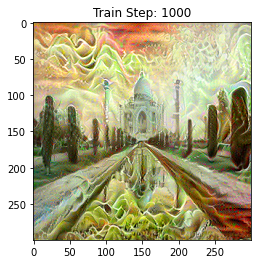

In [21]:
epochs = 10
steps_per_epoch = 100

images = []

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step+=1
    train_step(target_img)
    if not step%20:
      images.append((np.squeeze(target_img.read_value(), 0)*255.).astype(np.uint8))
  plt.imshow(np.squeeze(target_img.read_value(), 0))
  plt.title('Train Step: {}'.format(step))
  plt.show()

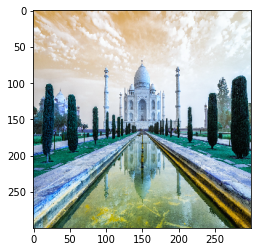

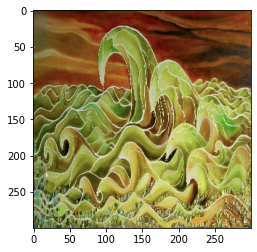

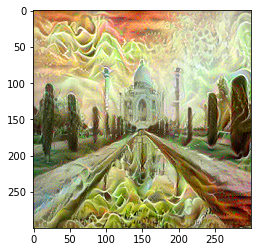

In [22]:
plt.imshow(content[0])
plt.show()
plt.imshow(style[0])
plt.show()
plt.imshow(target_img[0])
plt.show()

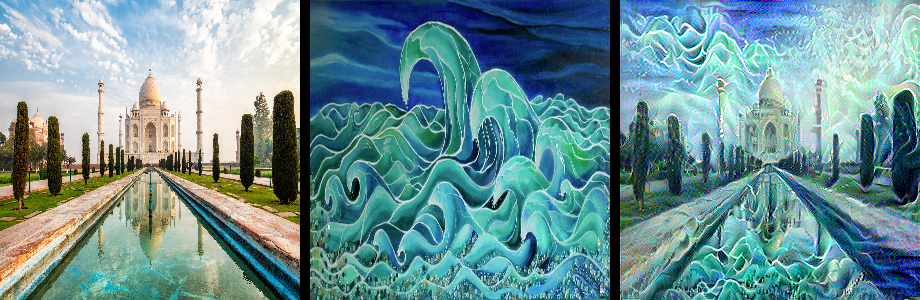

In [23]:
from google.colab.patches import cv2_imshow
final = np.hstack((np.asarray(content[0])*255., np.zeros((content.shape[1], 10, 3)), np.asarray(style[0])*255., 
                   np.zeros((content.shape[1], 10, 3)), np.asarray(target_img[0])*255.))
cv2_imshow(final)
# cv2_imshow(np.asarray(content[0])*255.)
# cv2_imshow(np.asarray(style[0])*255.)
# cv2_imshow(np.asarray(target_img[0])*255.)

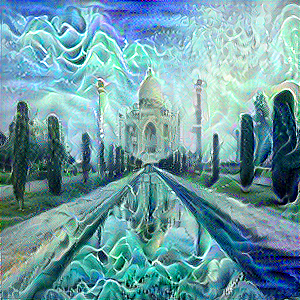

In [24]:
cv2_imshow(np.asarray(target_img[0])*255.)

In [25]:
import imageio
processed = []
for i in images:
  b, g, r = cv2.split(i)
  processed.append(cv2.merge((r, g, b)))

imageio.mimsave('NST2.gif', processed)